# **Modelagem de tópicos em reviews**

Este notebook, visa encontrar tópicos recorrentes em reviews de pedidos feitos em grandes marketplaces.

**Irei seguir com:**

1. Seleção das reviews que (em teoria) são negativas — explicação no notebook 03_0.

2. Preprocessamento das reviews.

3. Modelagem de tópicos.

4. Entendimento dos tópicos.

5. Teste do modelo e revisão.

## **Importando os dados**

Começarei importando os dados relevantes e os separando em treino e teste, desta forma poderei avaiar se a técnica de modelagem de tópicos esta funcionando corretamente em dados novos.

In [1]:
# importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import spacy
from spacy.tokens import Doc
from spacy.lang.pt.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from pathlib import Path

In [2]:
# configurar estilo do seaborn
sns.set_style('darkgrid')

# carregar spacy (modelo português)
nlp = spacy.load('pt_core_news_md')

In [3]:
def load_dataset_reviews(dataset_path: Path, max_score: int):
    '''
    Função para carregar as reviews a partir do dataset no caminho informado.

    Parâmetros:
    -----------
    dataset_path : Path
        Path para carregar os dados.
    max_score : int
        Score máximo das reviews a serem retornadas.

    Retorno:
    --------
    DataFrame
        As reviews carregadas.
    '''
    df = pd.read_csv(dataset_path)

    # manter apenas onde review score é menor ou igual ao score máximo
    df = df[df.review_score <= max_score]

    # unir título e mensagem das reviews
    reviews = df.review_comment_title + '. ' + df.review_comment_message
    scores = df.review_score

    # remover reviews nulas ou duplicadas
    reviews.dropna(inplace=True)
    reviews.drop_duplicates(inplace=True)

    scores = scores[reviews.index]

    return pd.DataFrame({ 'review' : reviews, 'score' : scores })

def train_test_split_reviews(reviews):
    '''
    Função para separar as reviews em dados de treino e teste
    '''
    return train_test_split(reviews, test_size=0.2, random_state=42)

In [4]:
# carregar reviews
reviews = load_dataset_reviews(Path('../artifacts/data_ingestion/data.csv'), 3)

# separar em treino e teste
train_reviews, test_reviews = train_test_split_reviews(reviews)

## **Preprocessando as reviews**

Eu irei criar uma função para facilitar o processo de limpeza das reviews.

**Alguns pontos que notei ao fazer o tuning do modelo de tópicos, é que na etapa de preprocessamento, eu devo:**

* Corrigir alguns erros e abreviações de digitação muito comuns como "kd" para "cadê", "vc" para "você" e "vei" para "veio", por exemplo.

* Declarar alguns stopwords, pois algumas palavras muito comuns (algumas até mesmo, erradas) nas reviews, dificultam o algoritmo de modelagem a encontrar os tópicos corretos.

* Substituir palavras com sentidos similares por uma única palavras, desta forma o algoritmo tem resultados melhores.

* Remover palavras que, após o preprocessamento, sejam iguais e consecutivas, pois isto afeta na vetorização das palavras para gerar os ngrans.

**Nota:** os pontos acima não foram documentados a frente com o objetivo de manter este notebbok mais limpo e entendível. Portanto, estes pontos eu anotei acima, conforme fui percebendo-os.

In [7]:
def prepare_reviews(
    reviews,
    typos_correction_dict,
    custom_stop_words_list,
    similar_words_substitution_dict):
    '''
    Função para processar as reviews.

    Parâmetros
    ---
    * reviews: as reviews para processar
    * typos_correction_dict: erros para corrigir
    * custom_stop_words_list: lista de stopwords customizada
    * similar_words_substitution_dict: palavras similares para substituir

    Retorno
    ---
    * docs: lista de spacy docs, contendo as reviews processadas
    * selecetd_docs_idx: lista com os indices das reviews originais que estão presentes em docs
    '''

    # corrigir erros e abreviações
    # também tranformar todas as palvras para minúsculas
    reviews_corrected = []
    for review in reviews:
        correct_review = review.lower()

        for typo, correction in typos_correction_dict.items():
            correct_review = re.sub(rf'\b{typo}\b', correction, correct_review)

        reviews_corrected.append(correct_review)

    # transformar as reviews em spacy docs
    reviews_docs = [doc for doc in nlp.pipe(reviews_corrected)]

    # atualizar stop words
    stopwords = STOP_WORDS | set(custom_stop_words_list)

    # limpar as reviews
    docs_clean = []
    selected_docs_idx = []

    for idx, doc in enumerate(reviews_docs):
        words = []

        for token in doc:
            # ignorar palvras que contenham números
            if not token.is_alpha:
                continue

            # pegar lemma da palavra
            final_word = token.lemma_.lower()

            # ignorar stopwords
            if token.text in stopwords or final_word in stopwords:
                continue

            # ignorar lemma se consistir em mais de uma palvra. Ex: dele -> de + ele
            if len(final_word.split()) > 1:
                continue

            # substituir palavras similares
            for w, values in similar_words_substitution_dict.items():
                if final_word in values or token.text in values:
                    final_word = w
                    break

            words.append(final_word)

        # remover palavras duplicatas seguidas
        unique_words = []
        for i, word in enumerate(words):
            if i < len(words) - 1:
                if word == words[i + 1]:
                    continue
            unique_words.append(word)

        # criar doc apenas se houver palavras em 'unique_words'
        if len(unique_words) > 0:
            # cirar a lista de espaços para o spacy doc
            spaces = [True] * len(unique_words)

            # último espaço deve ser Falso
            spaces[-1] = False

            clean_doc = Doc(nlp.vocab, unique_words, spaces)

            docs_clean.append(clean_doc)
            selected_docs_idx.append(idx)

    return docs_clean, selected_docs_idx

In [8]:
# parâmetros da função prepare_reviews
typos_correction_dict = {
    'ñ' : 'não',
    'kd' : 'cadê',
    'vc' : 'você',
    'vcs' : 'vocês',
    'vei' : 'veio',
    'demor' : 'demora',
    'hj' : 'hoje',
    'aind' : 'ainda',
    'pq' : 'porquê',
    'insacisfeito' : 'insatisfeito',
    'lamenetável' : 'lamentável',
    'retor' : 'retorno'
}

custom_stop_words_list = [
    'não', 'nao', 'otimo', 'ótimo', 'fiscal', 'lannister', 'targaryen', 'stark', 'comprei', 'comprar', 'nota',
    'capa', 'cadeira', 'preto', 'cartucho', 'casa', 'jogo', 'tecido',
    'relogio', 'relógio', 'site', 'anuncio', 'anunciar', 'caixa', 'cor',
    'pro', 'pra', 'dar', 'ir', 'ok', 'com', 'hoje', 'ser', 'si',
    'velho', 'usb', 'xper', 'queen', 'king', 'ha', 'eu', 'etc', 'eh', 'nf',
    'ne', 'naar', 'ai', 'gostar', 'ola', 'olá', 'ate', 'tb', 'td', 'to', 'ta', 'so',
    'dia', 'noite', 'tarde', 'item', 'ja', 'já', 'kit', 'loja'
]

similar_words_substitution_dict = {
    'receber' : [ 'entregar', 'entrega', 'recebi', 'chegar', 'chegou', 'receber' ],
    'pagar' : [ 'pagamento', 'pagar', 'paguar', 'paguei' ],
    'recomendar' : [ 'recomendado', 'recomendar', 'recomendaria', 'recomendavel', 'recomendo', 'recomento' ],
    'falta' : [ 'falta', 'faltar' ],
    'demora' : [ 'demora', 'demorar', 'demorou', 'demorado' ],
    'devolver' : [ 'devolver', 'devolução', 'devolucao' ],
    'atraso' : [ 'atraso', 'atrasado' ],
    'vir' : [ 'veio', 'vir' ],
    'erro' : [ 'erro', 'errar' ],
    'ruim' : [ 'ruim', 'horrível', 'lamentável' ],
    'produto' : [ 'produto', 'produtos', 'aperelho' ],
    'retorno' : [ 'retorno', 'retornar' ],
    'defeito' : [ 'defeito', 'quebrado', 
                'quebrada', 'amassar', 
                'amassado', 'amassada', 
                'defeituoso', 'defeituosa',
                'estragar', 'estragado',
                'estragada' ],
    'falso' : [ 'falso', 'falsificar' ]
}

In [9]:
# preprocessar reviews
reviews_docs, selected_idx = prepare_reviews(
    train_reviews.review,
    typos_correction_dict,
    custom_stop_words_list,
    similar_words_substitution_dict
)

## **Vetorizar as reviews**

A próxima etapa é vetorizar reviews, para que possam ser utilizadas no modelo de modelagem de tópicos.

A técnica que irei utilizar será TFIDF Vectorizer, pois o algoritmo exige que os vetores sejam no formato de Bag of Words, no entanto,TFIDF tem a vantagem de selecionar palavras mais importantes. Depois, criarei um bag of words com o vocabulário proveniente do TFIDF.

In [11]:
def vectorize_docs(docs, ngram_range, max_df, min_df, max_features):
    """
    Função para vetorizar as reviews em formato de spacy docs.

    Parâmetros
    ---
    * docs: os spacy docs para vetorizar
    * ngram_range: o tamanho dos ngrans
    * max_df: frequência de documento máxima
    * min_df: frequência de documento mínima
    * max_features: tamanho máximo dos vetores

    Retorno
    ---
    * vectorizer: o vetorizador
    * docs_vectors: os spacy docs vetorizados
    """

    # aplicar TFIDF
    tfidf_vectorizer = TfidfVectorizer(
        ngram_range=ngram_range,
        strip_accents='unicode',
        max_df=max_df,
        min_df=min_df,
        max_features=max_features,
        binary=True
    )
    tfidf_vectorizer.fit([doc.text for doc in docs])

    # criar BOW com TFIDF
    bow_vectorizer = CountVectorizer(ngram_range=(1,2), vocabulary=tfidf_vectorizer.get_feature_names_out().tolist(), strip_accents='unicode', binary=True)
    docs_vectors = bow_vectorizer.fit_transform([doc.text for doc in docs])

    return bow_vectorizer, docs_vectors

In [9]:
# vetorizar os documentos
vectorizer, reviews_vectors = vectorize_docs(
    docs=reviews_docs,
    ngram_range=(1, 2),
    max_df=1.0,
    min_df=0.009,
    max_features=160
)

In [10]:
# mostrar tamnaho dos vetores e as palvras que os compoêm
print('Tamanho dos vetores:', vectorizer.get_feature_names_out().shape[0])
print('Palavras representadas nos vetores:\n', vectorizer.get_feature_names_out())

Tamanho dos vetores: 142
Palavras representadas nos vetores:
 ['achar' 'acontecer' 'aguardar' 'aguardo' 'anuncio' 'atendimento' 'atraso'
 'atraso receber' 'avaliar' 'cancelamento' 'cancelar' 'caro' 'cartao'
 'certo' 'cliente' 'compra' 'compra receber' 'compro' 'conforme'
 'conseguir' 'consigo' 'constar' 'contato' 'correio' 'correto' 'cumprir'
 'data' 'defeito' 'defeito produto' 'deixar' 'demora' 'demora receber'
 'descricao' 'dever' 'devolver' 'devolver produto' 'diferente' 'dinheiro'
 'dinheiro volta' 'email' 'embalagem' 'embalar' 'empresa' 'entrar'
 'entrar contato' 'enviar' 'enviar produto' 'envio' 'erro' 'erro produto'
 'erro receber' 'esperar' 'falar' 'falso' 'falta' 'ficar' 'fiquei' 'fiz'
 'fiz compra' 'foto' 'frete' 'funcionar' 'haver' 'imagem' 'incompleto'
 'infelizmente' 'inferior' 'informacao' 'informar' 'insatisfeito' 'mandar'
 'material' 'mercadoria' 'modelo' 'nenhum' 'ninguem' 'obtir' 'original'
 'outro' 'outro produto' 'pagar' 'pagar frete' 'parceiro' 'passar' 'peca'
 'pe

## **Modelando tópicos**

Eu irei usar o modelo LDA (Latent Dirichlet Allocation) para encontrar tópicos recorrentes nas reviews. Basicamente, este modelo assume que cada documento é uma mistura de tópicos e cada tópico é uma mistura de palavras. Com isto em mente, o modelo busca encontrar distribuições de palavras e tópicos que melhor se adequam aos documentos, permitindo a análise das revisões em tópicos com base em suas palavras.

No entanto, por ser um modelo não supervisionado, ele precisa que eu informe a quantidade de tópicos que ele tentará encontrar. Felizmente, existe uma maneira simples de encontrar o número ideal de tópicos, que é calculando o quão parecido são os documentos gerados pelo modelo em comparação com os originais.

Farei isto usando a classe LatentDirichletAllocation da biblioteca scikit-learn, que permite calcular esta tal similaridade (que eu falei acima), pelo método "perplexity".

In [11]:
def calculate_lda_perplexities(vectors, min_topics, max_topics, max_iter):
    '''
    Função que calcula as perplexidades dos modelos LDA para os tópicos entre [min_topics, max_topics].
    '''

    perplexities = []

    for topics in range(min_topics, max_topics + 1):
        lda_model = LatentDirichletAllocation(n_components=topics, max_iter=max_iter, random_state=42)
        lda_model.fit(vectors)
        
        perplexities.append((topics, lda_model.perplexity(vectors)))

    return perplexities

def display_lda_perplexities(perplexities):
    '''
    Função que plota um gráfico que mostra a perplexidade dos modelos LDA para cada quantidade de tópicos.
    '''

    # separar os tópicos e perplexidades
    topics = [p[0] for p in perplexities]
    perplexitie = [p[1] for p in perplexities]

    # plotar perplexidade por tópico
    plt.plot(topics, perplexitie, linewidth=3.0)

    # configurar plot
    plt.title('Perplexidade X Tópicos', pad=20, fontsize=16, fontweight='bold', color='#727272')

    plt.xlabel('Tópicos', fontsize=10, color='#555')
    plt.ylabel('Perplexidade', fontsize=10, color='#555')
    
    plt.xticks(range(min(topics), max(topics) + 1))

    plt.grid(visible=False)
    plt.grid(visible=True, axis='x', color='#DDD')

    plt.gca().set_facecolor('#FFF')

    plt.tight_layout()

In [12]:
# calcular melhor quantidade de tópicos
perplexities = calculate_lda_perplexities(
    vectors=reviews_vectors,
    min_topics=2,
    max_topics=10,
    max_iter=100
)

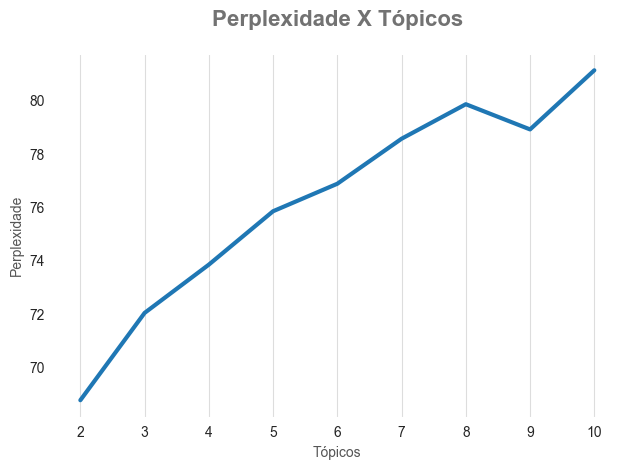

In [13]:
# plotar perplexidades por tópico
display_lda_perplexities(perplexities)

O melhor número de tópicos que o modelo conseguiu encontrar foi 2 (quanto menor a perplexidade mais parecidos são os documentos).

### **Tunagem e analise dos tópicos**

Agora que o número de tópicos já foi definido, irei tentar compreender oque cada tópico se refere. Para isso, irei analizar:

* as palavras mais frequentes para cada tópico.
* alguns exemplos de reviews e os tópicos que elas tem maior probabilidade.

Além disto, irei tunar os parêmetros do modelo para eliminar o máximo possível de problemas. A saber, o modelo têm dois parâmetros fundamentais, um que indica a influência de cada documento (review) tem sobre os tópicos e outro, a influência das palavras em cada tópico.

In [14]:
# treinar o melhor modelo LDA
lda_model = LatentDirichletAllocation(n_components=2, doc_topic_prior=1.0, topic_word_prior=0.15, max_iter=100, random_state=42)
lda_model.fit(reviews_vectors)

LatentDirichletAllocation(doc_topic_prior=1.0, max_iter=100, n_components=2,
                          random_state=42, topic_word_prior=0.15)

In [15]:
# calcular perplexidade do modelo
lda_model.perplexity(reviews_vectors)

68.07872607878046

In [19]:
def show_top_words_frequency_per_topic(k_top, lda_model, vocab, figsize):
    '''
    Função que mostra as k palavras mais frequentes em cada tópico encontrado pelo modelo LDA.
    '''

    topics_num = lda_model.components_.shape[0]
    fig, axes = plt.subplots(nrows=topics_num, ncols=1, figsize=figsize)

    # noramlizar freqûencia de palavras
    components_norm = lda_model.components_ / lda_model.components_.sum(axis=1).reshape(-1, 1)

    for topic in range(topics_num):
        # selecionar e ordenar as palavras mais frequentes no tópico em questão
        sorted_top_words_idx = np.argsort(components_norm[topic, :])[::-1][:k_top]

        top_words = vocab[sorted_top_words_idx]
        top_words_frequency = components_norm[topic, sorted_top_words_idx]

        data = pd.DataFrame({'Palavras' : top_words, 'Frequência' : top_words_frequency})

        # plotar a frequência das palavras
        sns.barplot(data=data, x='Palavras', y='Frequência', orient= 'v', ax=axes[topic])

        # configurar plot
        axes[topic].set_title(f'Frequência de palavras para tópico {topic + 1}', pad=20, fontsize=20, fontweight='bold', color='#727272')

        axes[topic].set_xlabel('', fontsize=10, color='#555')
        axes[topic].xaxis.grid(color='#DDD')
        axes[topic].yaxis.grid(visible=False)
        axes[topic].set_facecolor('#FFF')
        
        axes[topic].xaxis.set_tick_params(labelsize=14, labelcolor='#555')
        axes[topic].yaxis.set_tick_params(labelsize=14, labelcolor='#555')

    plt.tight_layout(h_pad=2)

def classify_reviews_in_topics(reviews, lda, vectorizer, threshold=0):
    reviews_docs, selected_idx = prepare_reviews(
        reviews,
        typos_correction_dict,
        custom_stop_words_list,
        similar_words_substitution_dict)
    
    selected_reviews = reviews.iloc[selected_idx]
    reviews_vectors = vectorizer.transform([doc.text for doc in reviews_docs])
    reviews_topics_percentages = lda.transform(reviews_vectors)

    reviews_df = {
        'review' : [],
        'topic_0' : [],
        'topic_1' : [],
    }

    for i, percentages in enumerate(reviews_topics_percentages):
        reviews_df['review'].append(selected_reviews.iloc[i])

        if reviews_vectors[i].sum() == 0 or np.abs(percentages[0] - percentages[1]) <= threshold:
            reviews_df['topic_0'].append(np.nan)
            reviews_df['topic_1'].append(np.nan)

        else:
            reviews_df['topic_0'].append(percentages[0])
            reviews_df['topic_1'].append(percentages[1])

    return pd.DataFrame(reviews_df)

def show_classified_reviews_topics_percentages(classified_reviews):
    '''
    Função que mostra a porcentagem que cada tópico está relacionado com cada review.
    '''

    for i, row in classified_reviews.iterrows():
        print(f'Review {i}', end=' | ')

        if np.isnan(row['topic_0']):
            print('Inconclusivo', end='')

        else:
            print(f'Tópico 0: {round(row["topic_0"], 2)}', end=' | ')
            print(f'Tópico 1: {round(row["topic_1"], 2)}', end='')

        print(f'\n{row["review"]}')

        print('-' * 80 + '\n')

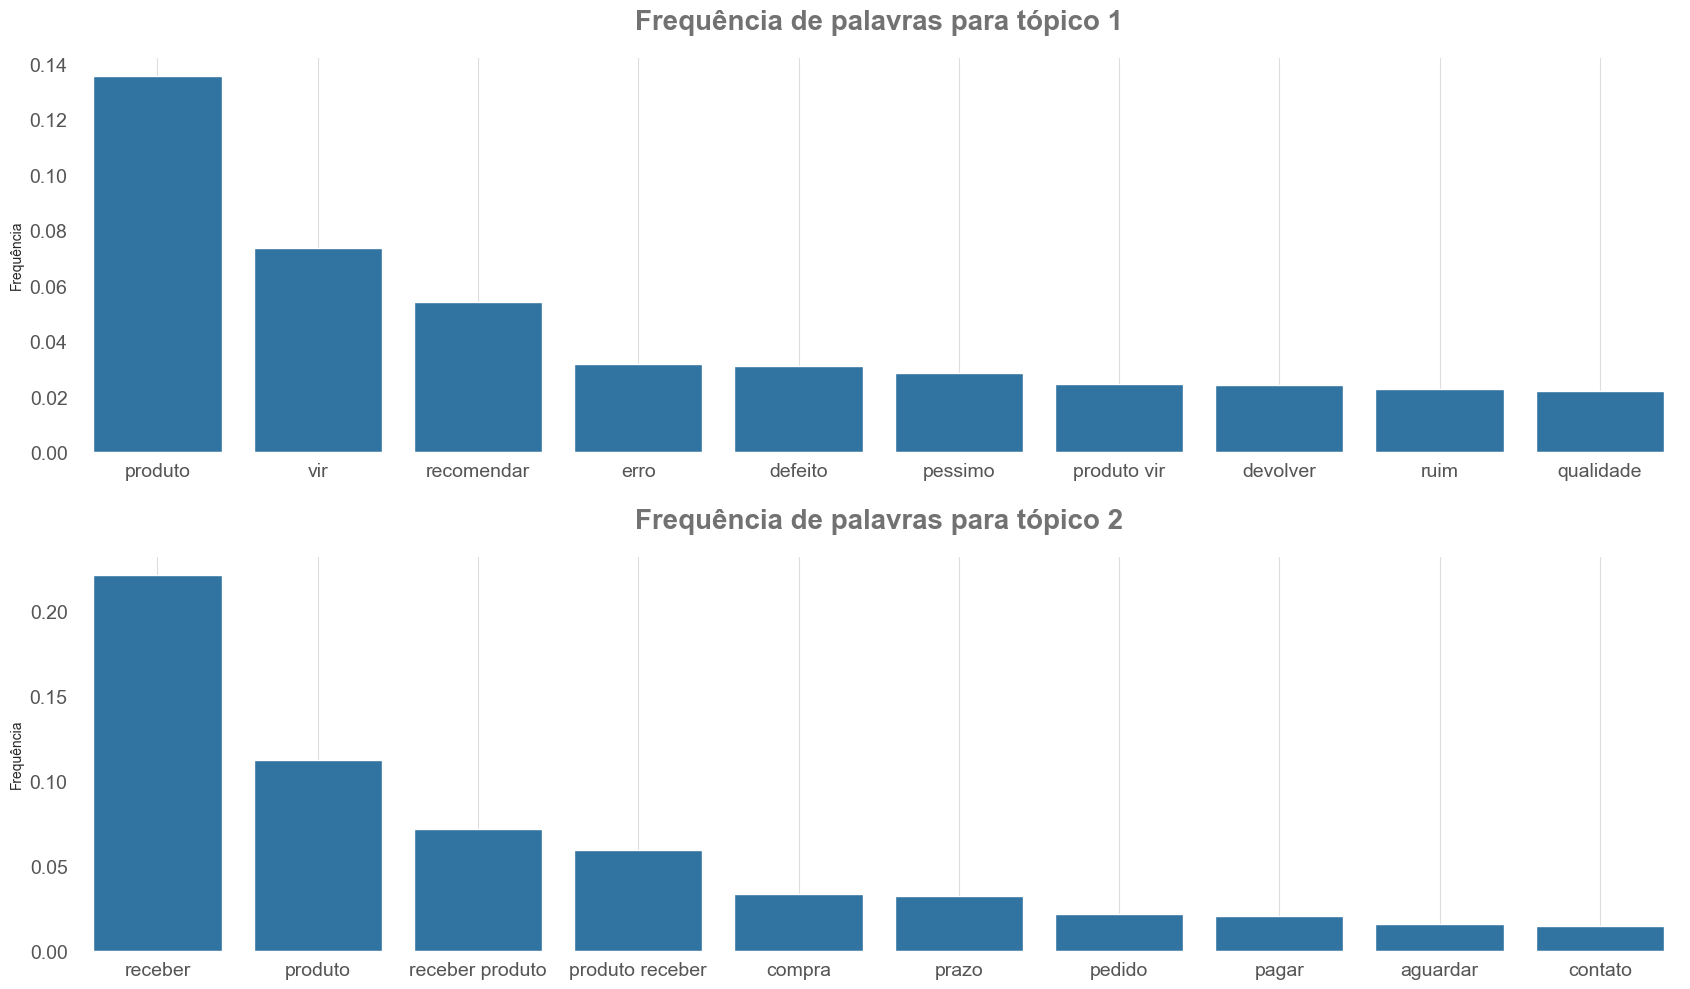

In [20]:
# mostrar frequência de palavras por tópico
show_top_words_frequency_per_topic(
    k_top=10,
    lda_model=lda_model,
    vocab=vectorizer.get_feature_names_out(),
    figsize=(17, 10)
)

In [21]:
# classificar reviews em tópicos
classified_reviews = classify_reviews_in_topics(
    reviews=train_reviews.review,
    lda=lda_model,
    vectorizer=vectorizer,
    threshold=0.15
)

In [22]:
# visualizar quantidades de reviews em cada tópico
print(f'Reviews inconclusivas: {classified_reviews.topic_0.isna().sum()}')
print(f'Reviews no tópico 1: {(classified_reviews.topic_0 > classified_reviews.topic_1).sum()}')
print(f'Reviews no tópico 2: {(classified_reviews.topic_1 > classified_reviews.topic_0).sum()}')

Reviews inconclusivas: 448
Reviews no tópico 1: 867
Reviews no tópico 2: 1022


In [23]:
# visualizar as reviews com as porcentagens para cada tópico
show_classified_reviews_topics_percentages(classified_reviews)

Review 0 | Tópico 0: 0.12 | Tópico 1: 0.88
Razoavel. comprei tres produtos, paguei pelo frete de cada um deles e recebi apenas um em casa, os demais fui obrigada a buscar nos correios. Qual a lógica, mesmo vendedor e entregador, fretes individuais e um 
--------------------------------------------------------------------------------

Review 1 | Tópico 0: 0.67 | Tópico 1: 0.33
Péssimo. Aparelho usado
--------------------------------------------------------------------------------

Review 2 | Tópico 0: 0.88 | Tópico 1: 0.12
Pessimo. Comprei um Produto , e veio outro completamente diferente !!!!!
--------------------------------------------------------------------------------

Review 3 | Inconclusivo
Lamenetável.... Boa Noite

é lamentável, esta loja que tantas compras eu ja fiz e hoje não me da satisfação sequer de um relógio na importância de 50,00 reais ... um produto com defeito e até agora não me deu retor
------------------------------------------------------------------------------

Eu optei por realizar uma tunagem manual do modelo, pois conforme alterava os parâmetros, percebia algumas palavras que poderiam ser tratadas para melhorar o desempenho. De forma geral:

* Conisgo descrever os tópicos em 1 e 2, sendo o primeiro relacionado a "produto" e o segundo relacionado a "entrega".

* O primeiro tópico considera reclamações ao produto como:

    * falta de qualidade.

    * ser diferente da foto anunciada.

    * características diferentes do que foi pedido.

* O segundo tópico considera reclamações a entrega como:

    * não receber produto.

    * atrazo.

    * falta de itens.

* Pelos parâmetros utilizados pelo modelo, consigo inferir que cada review está mais relacionada a um tipo de reclamação geralmente — ou seja, dificilmente uma reclamação está relacionada ao produto e entrega.

* Algumas das palavras mais relevantes no tópico 1 são — isto, considerando as palvras após o preprocessamento:

    * "produto"

    * "vir"

    * "recomendar"

    * "erro"

    * "defeito"

* Algumas das palavras mais relevantes no tópico 2 são — isto, considerando as palvras após o preprocessamento:

    * "receber"

    * "produto"

    * "compra"

    * "prazo"

    * "pedido"

* O modelo não se adequa a todas as reviews. Caso só haja palavras desconhecidas pelo modelo, os resultados são inconclusivos.

* O modelo consegue acertar o tópico correto de muitas reviews, mas ainda há alguns erros (não observei todas as reviews).

* Os erros ocorrem com freqûencia onde a diferença de porcentagem entre os tópicos é pequena. Por isso, usarei um limiar para evitar estas reviews e cometer menos erros.

* Durate a tunagem percebi que algumas reviews (poucas) são incoerentes, ou seja, não são realmente reclamações.

* Em alguns poucos casos, as reviews não estão relacionadas a nenhum tópico.

Outras análises eu irei reservar para o notebook 03_0.

## **Avaliando modelo nas reviews de teste**

Como eu não observei como o modelo classifica todos as reviews de treino, irei analisar todas as reviews de teste (que são poucas) para tirar um veredito final do modelo.

In [24]:
# classificar reviews de teste em tópicos
classified_test_reviews = classify_reviews_in_topics(
    reviews=test_reviews.review,
    lda=lda_model,
    vectorizer=vectorizer,
    threshold=0.15
)

In [25]:
# visualizar quantidades de reviews em cada tópico
print(f'Reviews inconclusivas: {classified_test_reviews.topic_0.isna().sum()}')
print(f'Reviews no tópico 1: {(classified_test_reviews.topic_0 > classified_test_reviews.topic_1).sum()}')
print(f'Reviews no tópico 2: {(classified_test_reviews.topic_1 > classified_test_reviews.topic_0).sum()}')

Reviews inconclusivas: 103
Reviews no tópico 1: 207
Reviews no tópico 2: 273


#### **Reviews no tópico 1**

In [26]:
# mostrar reviews no tópico 1
for i, r in classified_test_reviews[classified_test_reviews.topic_0 > classified_test_reviews.topic_1].iterrows():
    print(f'Review {i}')
    print(r['review'].strip())
    print('-' * 120)

Review 11
Cor errada. Comprei o produto com a cor laranja e veio com a cor amarela.
------------------------------------------------------------------------------------------------------------------------
Review 12
PRODUTO VEIO INCORRETO. Comprei um modelo e veio outro. Espero que troquem por o produto correto!
------------------------------------------------------------------------------------------------------------------------
Review 20
Produto com defeito. Comprei duas cadeiras, uma o assento ñ encaixa corretamente e a outra veio sem as borrachinhas para acabamento
------------------------------------------------------------------------------------------------------------------------
Review 24
Cor do produto errada . Muita falta de atenção, pedi as toalhas pretas e vieram brancas.
------------------------------------------------------------------------------------------------------------------------
Review 25
quero devolução. 1ª vez,Quero devolver o proturo, por se tratar de um lei

**Observações:**

* O modelo classificou 19 reviews na categoria errada. A saber, as reviews: 55, 63, 81, 110, 199, 211, 212, 214, 230, 285, 311, 378, 448, 449, 480, 502, 533, 537 e 552.

* Existem 6 reviews que não perctencem a nenhuma das duas categorias: A saber, as reviews: 60, 164, 253, 353, 360, 520

* Das reviews que fazem parte de algum tópico (207 - 6), 25 foram classificadas inconrretamente, ficando com uma **precisão de 90%**.

**Agora posso definir melhor este tópico como estando relacionado com:**

1. Qualidade do produto.

2. Características diferentes da foto.

3. Características diferentes do que foi pedido.

4. Embalagem.

**Portanto vou nomear esta categoria como "Produto".**

In [27]:
# mostrar reviews no tópico 2
for i, r in classified_test_reviews[classified_test_reviews.topic_1 > classified_test_reviews.topic_0].iterrows():
    print(f'Review {i}')
    print(r['review'].strip())
    print('-' * 120)

Review 0
Nao chegou. Meu produto ainda não chegou
------------------------------------------------------------------------------------------------------------------------
Review 1
não reconmendo. Demora na entrega
------------------------------------------------------------------------------------------------------------------------
Review 3
Entrega de apenas uma cap. Comprei duas unidades, mas na embalagem veio apenas uma, quero saber o que houve, pois paguei dois e recebi apenas um.
------------------------------------------------------------------------------------------------------------------------
Review 4
Falta de comprometimento. Como está especificado no pedido, solicitei o cadeira branca com lilás e recebo uma nota fiscal com a cadeira branca com roxa, é o produto branco com roxo, então a minha escolha não valeu de nada....
------------------------------------------------------------------------------------------------------------------------
Review 6
prazo. apesar de entrega

**Observações:**

* O modelo classificou 23 reviews na categoria errada. A saber, as reviews: 4, 34, 68, 72, 99, 128, 132, 136, 158, 184, 203, 208, 246, 280, 295, 456, 483, 497, 507, 518, 523, 539 e 544.

* Existem 6 reviews que não perctencem a nenhuma das duas categorias. A saber, as reviews: 130, 206, 301, 331, 345 e 542.

* Das reviews que fazem parte de algum tópico (273 - 6), apenas 23 foram classificadas inconrretamente, ficando com uma **precisão de 91%**.

**Agora posso definir melhor este tópico como estando relacionado com:**

1. Não recebimento de produto.

2. Atrazo na entrega.

3. Entrega parcial.

4. Atendimento.

**Portanto vou nomear esta categoria como "Entrega".**

## **Conclusão**

Apartir de um modelo não supervisionado de treinamento, consegui identificar dois tópicos comuns nas reviews: Produto e Entrega.

**O tópico de Produto aborda assuntos como:**

1. Qualidade do produto.

2. Características incorretas do produto (em relação ao que fo pedido ou ainda, em relação a foto).

3. Embalagem em que veio o produto.

**Já o tópico de Entrega aborda:**

1. Produtos não entregues.

2. Atrazo nas entregas.

3. Produtos entregues parcialmentes.

Em relação ao tópico Produto, o modelo teve precisão de 90% nos dados de teste, e em relação ao tópico de Entrega, 91%.

**Entre os pontos que afetam o desempenho do modelo posso destacar:**

* Erros de digitação.

* Carácter subjetivo das reviews.

* O tamanho limitado do vetor de palvaras conhecidas pelo modelo (apenas 129 palavras).

* Reviews com assuntos sem relação aos tópicos identificados.

* Incerteza do modelo em certas reviews.

* Reviews com avaliações sem sentido, por exemplo, ser avaliada em menos de 4 pontos, porpem com um comentário favorável.

**Nota final**

Apesar de o modelo não atingir uma precisão próxima dos 100%, posso dizer, com bases nos dados de teste, que o model se adequa em torno de 90% das reviews.

Soluções para amenizar esses erros, utilizando o memsmo modelo:

* utilizar o modelo apenas para as reviews com score 1 e 2.

* atribuir um peso de 90% (valor arbitrário) às contagens de cada tópico para penalizar os erros.

## **Validando solução para modelo**

Apenas para meio de validação, irei analizar se a solução acima realmente oferece um melhoria significativa.

In [28]:
# separar as reviews de teste com score menor ou igual a 2
low_score_reviews = test_reviews[test_reviews.score <= 2]

In [29]:
# classificar reviews em tópicos
classified_low_score_reviews = classify_reviews_in_topics(
    reviews=low_score_reviews.review,
    lda=lda_model,
    vectorizer=vectorizer,
    threshold=0.15
)

In [30]:
# visualizar quantidades de reviews em cada tópico
print(f'Reviews inconclusivas: {classified_low_score_reviews.topic_0.isna().sum()}')
print(f'Reviews no tópico 1: {(classified_low_score_reviews.topic_0 > classified_low_score_reviews.topic_1).sum()}')
print(f'Reviews no tópico 2: {(classified_low_score_reviews.topic_1 > classified_low_score_reviews.topic_0).sum()}')

Reviews inconclusivas: 71
Reviews no tópico 1: 156
Reviews no tópico 2: 216


In [31]:
# armazenar os indices das reviews classificadas erroneamente
wrong_product_idx = {55, 63, 81, 110, 199, 211, 
                     212, 214, 230, 285, 311, 378,
                     448, 449, 480, 502, 533, 537, 552}

wrong_delivery_idx = {4, 34, 68, 72, 99, 128, 132, 136,
                      158, 184, 203, 208, 246, 280, 295,
                      456, 483, 497, 507, 518, 523, 539, 544}

# pegar indices das reviews sobre Produto e Entrega, para as reviews com score <= 2
product_idx = classified_low_score_reviews[
    classified_low_score_reviews.topic_0 > classified_low_score_reviews.topic_1
    ].index

delivery_idx = classified_low_score_reviews[
    classified_low_score_reviews.topic_1 > classified_low_score_reviews.topic_0
    ].index

# calcular os erros que persistiram
remaining_product_erros = len(set(product_idx).intersection(wrong_product_idx))
remaining_delivery_erros = len(set(delivery_idx).intersection(wrong_delivery_idx))

print('Erros remanecentes para \'Produto\': ', remaining_product_erros)
print('Erros remanecentes para \'Entrega\': ', remaining_delivery_erros)

Erros remanecentes para 'Produto':  5
Erros remanecentes para 'Entrega':  10


Ao considerar apenas as reviews com score igual ou inferior a 2, eu consegui reduzir a quantidade de erros para mais da metade (nos dados de teste). Portanto, esta parece ser uma solução decente que evitará alguns erros nas classificações do modelo resultando em contagens mais precisas de reclamações.